In [ ]:
# 猫狗识别迁移学习
# 训练模型作为固定的特征提取器，只训练最后一层分类器

In [1]:
# wget -nc 'http://labfile.oss.aliyuncs.com/courses/1081/dogs_cats.zip'  # 下载数据
# unzip -o "dogs_cats.zip"  # 解压数据

SyntaxError: invalid syntax (314383058.py, line 1)

In [3]:
import os

data_path = []
data_name = []

for root, dirs, files in os.walk("./dogs_cats/train"):
    # 变量指定目录文件列表
    for image_file in files:
        image_path = os.path.join(root, image_file)
        data_path.append(image_path)
        data_name.append(image_file.split(".")[0])

len(data_path), len(data_name)

(25000, 25000)

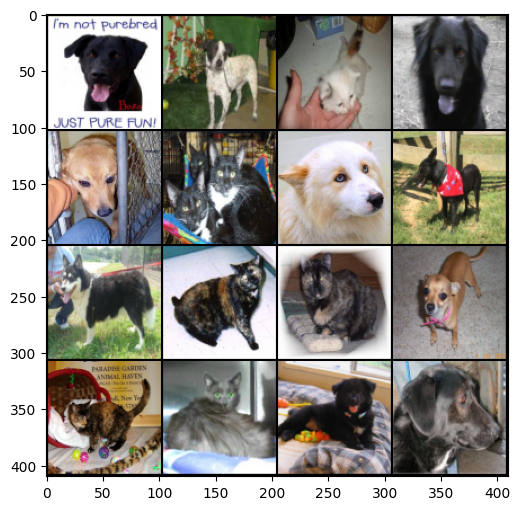

In [6]:
import random
from torchvision.utils import make_grid
from torchvision import transforms
from skimage import io, transform
import matplotlib.pyplot as plt

%matplotlib inline

# 随机抽取 16 张图片路径
img_path_list = random.sample(data_path, 16)

# 使用 skimage 根据路径读取图片并对显示尺寸进行裁剪
img_list = [
    transform.resize(io.imread(img_path), (100, 100), mode="reflect")
    for img_path in img_path_list
]
# 使用 torchvision 将图片处理成张量
img_list = [transforms.ToTensor()(img) for img in img_list]
# 将图片合并成每行四张的大图
img_show = make_grid(img_list, nrow=4, normalize=True)

# 创建 6 x 6 英寸 的图像窗口
plt.figure(figsize=(6, 6))

# img_show.permute(1, 2, 0) 是对图像张量进行维度重排。
# 原始张量的维度可能是 (C, H, W)，通过 permute(1, 2, 0) 将其变为 (H, W, C)，以便与 Matplotlib 期望的形状一致
plt.imshow(img_show.permute(1, 2, 0).numpy())

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(["cat", "dog"])
data_label = le.transform(data_name)
data_label

array([0, 0, 0, ..., 1, 1, 1])

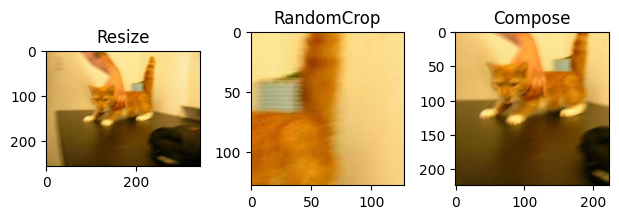

In [8]:
# 数据处理，数据加载器

import numpy as np

# 加载图片并转换为 PIL IMAGE
IMAGE = transforms.ToPILImage()(io.imread(data_path[0]))
# 尺寸变形
scale = transforms.Resize(256)
# 随机裁剪
crop = transforms.RandomCrop(128)
# 打包方法
composed = transforms.Compose([transforms.Resize(256), transforms.RandomCrop(224)])
# 将每个变换函数应用到一个样本上
fig = plt.figure()
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = np.array(tsfrm(IMAGE))  # PIL.image 转换成 np.ndarray
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.imshow(transformed_sample)

In [ ]:
# 猫狗识别迁移学习

In [1]:
import torch
from torchvision import models

# 从课程镜像服务器上下载 AlexNet 预训练模型
# torch.utils.model_zoo.load_url("https://cdn.aibydoing.com/hands-on-ai/files/alexnet-owt-4df8aa71.pth")
torch.load("../../data/model/alexnet-owt-4df8aa71.pth")
alexnet = models.alexnet(pretrained=True)
alexnet

C:\Users\91658\Miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\91658\Miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [2]:
# PyTorch 中所有层都会用一个变量 requires_grad 来表明这一层在反向传播时需不需要计算梯度
for param in alexnet.parameters():
    print(param.requires_grad)
# 后返回  16 组状态，虽然 AlexNet 有 20 层，但是池化层、Dropout、激活层等均没有可学习参数
# 需要学习参数的卷积层和全连接层实际上只有 8 个。每一个层中权重和偏置项各为 1 组参数，所以最终打印出 8 x 2 = 16 组状态

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [3]:
# 不需要更新权重，冻结参数
for param in alexnet.parameters():
    param.requires_grad = False
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [4]:
# 在 ImageNet 上完成预训练的 AlexNet 模型是 1000 个类别的多分类输出，替换这一层进行二分类

classifier = list(alexnet.classifier.children())  # 读取分类器全部层
# 将最后一层由 Linear(4096, 1000) 改为 Linear(4096, 2)
classifier[-1] = torch.nn.Linear(4096, 2)
alexnet.classifier = torch.nn.Sequential(*classifier)  # 修改原分类器
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
# 学习率：每迭代一个 step_size 次，学习率都将会是上一次的 gamma

# 如果 GPU 可用则使用 CUDA 加速，否则使用 CPU 设备计算
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [7]:
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数

# 只对 requires_grad TRUE 的进行优化
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, alexnet.parameters()), lr=0.001
)  # 优化器
# 学习率衰减，每迭代 1 次，衰减为初始学习率 0.5
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

criterion, optimizer, lr_scheduler

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.001
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 <torch.optim.lr_scheduler.StepLR at 0x2456a521510>)

In [8]:
epochs = 2
model = alexnet.to(dev)
print("Start Training...")
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(dev)  # 添加 .to(dev)
        labels = labels.to(dev)  # 添加 .to(dev)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(
                "Epoch [{}/{}], Batch [{}/{}], Train loss: {:.3f}".format(
                    epoch + 1, epochs, i + 1, len(train_loader), loss.item()
                )
            )

    correct = 0
    total = 0
    for images, labels in val_loader:
        images = images.to(dev)  # 添加 .to(dev)
        labels = labels.to(dev)  # 添加 .to(dev)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print("============ Test accuracy: {:.3f} =============".format(correct / total))

    lr_scheduler.step()  # 设置学习率衰减

Start Training...


NameError: name 'train_loader' is not defined

In [ ]:
torch.save(model.state_dict(), "model.pt")


In [ ]:
model_saved = alexnet
model_saved.load_state_dict(torch.load("model.pt"))
model_saved

In [ ]:
import requests

# 随机返回一只猫咪或狗狗的图片
random_api = "https://random-cat-dog.onrender.com"
content = requests.get(random_api).json()
with open("test.jpg", "wb") as f:
    f.write(requests.get(content["url"]).content)
plt.title(content["species"])
plt.imshow(io.imread("test.jpg"))


IMAGE = io.imread("test.jpg")
IMAGE = data_transforms["val"](IMAGE).unsqueeze(0)  # PyTorch 模型输入必须为 B*C*H*W
IMAGE.size()


torch.argmax(model_saved(IMAGE.to(dev)))  # 对测试数据进行推理

In [ ]:
# 卷积神经网络可视化

In [ ]:
conv1_weights = list(model_saved.parameters())[0]
conv1_images = make_grid(conv1_weights, normalize=True).cpu()
plt.figure(figsize=(8, 8))
plt.imshow(conv1_images.permute(1, 2, 0).numpy())



# AlexNet 第一层卷积核参数的形状是 的四维 Tensor，这样就可以得到上述 个的图片块了。显然，这些重构出来的图像基本都是关于边缘，条纹以及颜色的信息。

# 神经网络通过卷积核作为特征提取器，每一个卷积核对输入进行卷积，就产生一个特征图，例如说 AlexNet 第一层卷积层有 64 个卷积核，那么就有 64 个特征图

# 理想的特征图应该是稀疏的以及包含典型的局部信息。通过特征图可视化能有一些直观的认识并帮助调试模型，比如：特征图与原图很接近，说明它没有学到什么特征，如果特征图几乎是一个纯色的图，说明它太过稀疏，可能是模型特征图数太多了，也反映了卷积核太小。我们可以通过这些信息调整神经网络的参数。


def visualize(alexnet, input_data, submodule_name, layer_index):
    """
    alexnet: 模型
    input_data: 输入数据
    submodule_name: 可视化 module 的 name, 专门针对 nn.Sequential
    layer_index: 在 submodule 中的 index
    """
    x = input_data
    modules = alexnet._modules
    for name in modules.keys():
        if name == submodule_name:
            module_layers = list(modules[name].children())
            for i in range(layer_index + 1):
                if type(module_layers[i]) == torch.nn.Linear:
                    x = x.reshape(x.size(0), -1)  # 针对线性层
                x = module_layers[i](x)
            return x

        x = modules[name](x)



feature_maps = visualize(model_saved, IMAGE.to(dev), "features", 0)
feature_images = make_grid(feature_maps.permute(1, 0, 2, 3), normalize=True).cpu()
plt.figure(figsize=(8, 8))
plt.imshow(feature_images.permute(1, 2, 0).numpy())